# RNN İLE HAVAYOLU YOLCU SAYISI TAHMİNİ

1) İş Problemi

2) Veriyi Anlamak

3)Veriyi Hazırlamak

4) Modelleme

5) Değerlendirme

Business Problem

*Month*: Aylık olarak yer alan tarih degişlenidir

*Passengers*: İlgili işlem tarihindeki yolcu sayisini, yani aylık yolcu sayisini temsil etmektedir.

# Veriyi Anlamak (Data Understanding ⚛)

Gerekli Kütüphanelerin import işlemi


In [112]:
#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#Model degerlendirme ve veriyi scale edebilmemiz için kullanilacak olan kütüphaneler;
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Warningleri (Uyarılar) kapatmak için;
import warnings
warnings.filterwarnings("ignore")

#Tensorflow Warning (Uyarı) Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [113]:
import os
current_directory = os.getcwd()
print("Çalışma Dizini:", current_directory)

Çalışma Dizini: /content


In [114]:
df = pd.read_csv('/content/sample_data/international-airline-passengers.csv')

In [115]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [116]:
df.columns


Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [117]:
df.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':"Passangers"}, inplace=True)

In [118]:
df.head()

,Month,Passangers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [119]:
df.tail() #sonuna göz atılabilir.

,Month,Passangers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [120]:
df.shape # kaç veri var

(145, 2)

In [121]:
df.dtypes

Month          object
Passangers    float64
dtype: object

In [122]:
df.isnull().sum() # kaç tane eksik deger var

Month         0
Passangers    1
dtype: int64

In [123]:
df.describe().T #Acıklamasının transpozu

,count,mean,std,min,25%,50%,75%,max
Passangers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


Veriyi Hazirlamak (Data Preparation)

In [124]:
df = df[:144] # en sondaki satırı seçim dışında bırakıyoruz. ve yeniden atıyoruz.
df.tail()

,Month,Passangers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passangers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [126]:
df['Month'] = pd.to_datetime(df['Month']) # degişken tipini (datetime'a) güncelliyoruz.


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passangers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [128]:
print("Minimum Tarih: ", df["Month"].min()) # en ileri ve en geri tarihe bakıyoruz.
print("Maximum Tarih ", df["Month"].max())

Minimum Tarih:  1949-01-01 00:00:00
Maximum Tarih  1960-12-01 00:00:00


In [129]:
df.index = df["Month"]

In [130]:
df.head()

,Month,Passangers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [131]:
print(df)

                Month  Passangers
Month                            
1949-01-01 1949-01-01       112.0
1949-02-01 1949-02-01       118.0
1949-03-01 1949-03-01       132.0
1949-04-01 1949-04-01       129.0
1949-05-01 1949-05-01       121.0
...               ...         ...
1960-08-01 1960-08-01       606.0
1960-09-01 1960-09-01       508.0
1960-10-01 1960-10-01       461.0
1960-11-01 1960-11-01       390.0
1960-12-01 1960-12-01       432.0

[144 rows x 2 columns]


In [132]:
df.drop("Month",axis=1,inplace = True)

In [133]:
df.head()

,Passangers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [134]:
result_df = df.copy()

In [135]:
result_df.head()

,Passangers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: title={'center': 'Monthly airline passangers'}, xlabel='Month'>

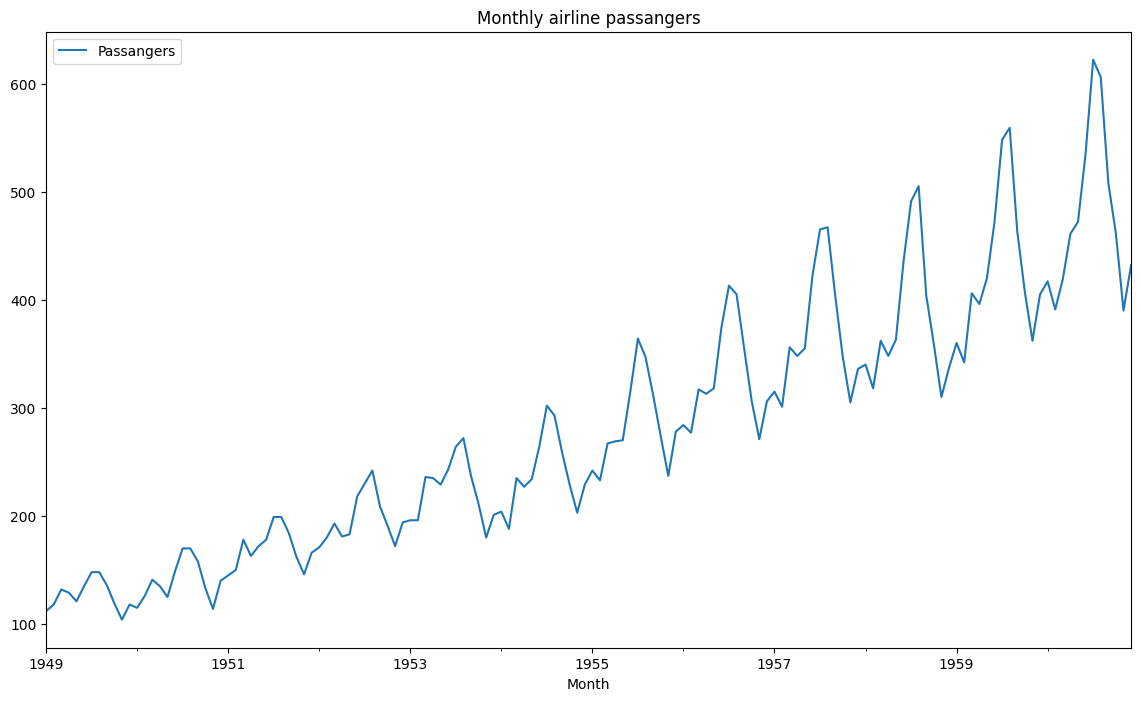

In [136]:
df.plot(figsize=(14,8), title="Monthly airline passangers")

In [137]:
data = df["Passangers"].values

In [138]:
type(data)

numpy.ndarray

In [139]:
data[:5]


array([112., 118., 132., 129., 121.])

In [140]:
data = data.astype('float32')


In [141]:
data.shape

(144,)

In [142]:
data = data.reshape(-1,1)

In [143]:
data.shape

(144, 1)

Veri rastgele bir biçimde test ve train olarak ayrılırsa yani scikitlearn kütüphanesindeki train_test_split fonksiyonu ile Zaman serisi olmasından gelen örüntü özelligini yitirir!

Eğer veri bir zaman serisi verisi ise, veriyi karıştırmadan ayırmak önemlidir. Bu durumda veriyi kronolojik sıraya göre ayırmalısınız. Genellikle en eski veriyi eğitim setine, daha yeni veriyi test setine ayırmak tercih edilir.



In [144]:
def split_data(dataframe,test_size):
  """
  This function split a dataframe from where you want

  Parameters:
  dataframe : The dataframe you want to split.
  test_size : Size of dataFrame for testing (enter a percentage value).

  Returns:
  Train: dataframe to train the model.
  Test: dataframe to test the model.
  Position: Integer showing Where the dataframe is split from
  """
  position=int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test,position

In [145]:
print(split_data.__doc__)


  This function split a dataframe from where you want 

  Parameters:
  dataframe : The dataframe you want to split.
  test_size : Size of dataFrame for testing (enter a percentage value).

  Returns:
  Train: dataframe to train the model.
  Test: dataframe to test the model.
  Position: Integer showing Where the dataframe is split from 
  


In [146]:
train, test, position = split_data(data,0.33)

In [147]:
print(f"Size of the training set : {train.shape}\nsize of the test set : {test.shape}")

Size of the training set : (96, 1)
size of the test set : (48, 1)


Veri seti özellikle bagımsız degişkenler modele sokulmadan once; 0-1 arasına veya standart normal dönüşüme veya benzeri dönüşüm işlemlerine tabii tutulmalıdır.

In [148]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [149]:
train = scaler_train.fit_transform(train)

In [150]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [151]:
test = scaler_test.fit_transform(test)

In [152]:
train[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [153]:
test[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

Zaman serilerinde serinin t anındaki değeri EN FAZLA kendisinden bir önceki zaman birimindeki serinin değerinden ETKİLENİR !

t anı en çok t-1 anındaki değerlerden etkilenir. Bir önceki ayın değerlerini modele bir feature olarak koyalım.

In [154]:
def create_features(data, lookback):
    """
    Veri özelliklerini ve hedef değerlerini bir zaman penceresi (lookback) kullanarak oluşturan bir fonksiyon.

    Parametreler:
    data : numpy.ndarray
        Eğitim verisi veya girdi verisi. İki boyutlu bir diziyi kabul eder, genellikle bir zaman serisi.
    lookback : int
        Bir zaman penceresinin uzunluğu. Geçmiş verileri kaç zaman birimi geriye alacağımızı belirler.

    Returns:
    X : numpy.ndarray
        Özellik matrisi. Her satır, bir zaman penceresi içindeki geçmiş verileri içerir.
    Y : numpy.ndarray
        Hedef değer dizisi. Her bir değer, zaman penceresinin sonundaki hedef değeri temsil eder.
    """
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])

    return np.array(X), np.array(Y)



    """
    Veri özelliklerini ve hedef değerlerini bir zaman penceresi (lookback) kullanarak oluşturan bir fonksiyon.

    Parametreler:
    data : numpy.ndarray
        Eğitim verisi veya girdi verisi. İki boyutlu bir diziyi kabul eder, genellikle bir zaman serisi.
    lookback : int
        Bir zaman penceresinin uzunluğu. Geçmiş verileri kaç zaman birimi geriye alacağımızı belirler.

    Returns:
    X : numpy.ndarray
        Özellik matrisi. Her satır, bir zaman penceresi içindeki geçmiş verileri içerir.
    Y : numpy.ndarray
        Hedef değer dizisi. Her bir değer, zaman penceresinin sonundaki hedef değeri temsil eder.
    """


In [155]:
lookback = 1

In [156]:
#Train veri  seti
x_train, y_train = create_features(train, lookback)

In [157]:
#test veri  seti
x_test, y_test = create_features(test, lookback)

In [158]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [159]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


In [160]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


#Modelleme (Modelling)

In [161]:
model = Sequential() #diş özellikler

model.add(SimpleRNN(units = 45,
                    activation = 'relu',
                    input_shape = (x_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1)) # output katmanı (cıktıda bekledigimiz değer sayısal bir tahmin değeri)

In [162]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 45)                2115      
                                                                 
 dropout_2 (Dropout)         (None, 45)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 46        
                                                                 
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [163]:
#OPTİMİZASYON VE DEGERLENDİRME METRİKLERİ AYARLANMASI (iç özellikler)
model.compile(loss='mean_squared_error', optimizer = 'adam') #loss fonksiyonunu adam fonksiyonu minimize eder.relu

In [164]:

#Aşırı ogrenmeyi onlemek adına earlyStopping ayarlaması
#(EarlyStopping)
#Train setinde loss düşerken test setinde (patience kadar) dönem loss düşmezse dur
#verbose = raporlama durumunu ifade eder
#mode = min ise izledigimiz miktarın azalması durduğunda eğitim durur
  # = max ise izledigimiz miktarın artması durdugunda eğitim durur.
###-------------------------------------------------#####
#ModelCheckpoint
#filepath = modeli kaydetmek için isimlendirme,
#monitor = izleme metriği
#save_best_only=True En iyi modeli kaydeder.
#  save_weights_only = False ise tüm model özelliklerini kaydeder.

callbacks = [EarlyStopping(monitor='val_loss', patience = 3,verbose = 1,mode="min"),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss',mode="min",
                             save_best_only=True, save_weights_only = False,verbose=1)]

In [165]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=1,
                    epochs=64,
                    validation_data=(x_test,y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/64
95/95 [==============================] - ETA: 0s - loss: 0.0203
Epoch 1: val_loss improved from inf to 0.03304, saving model to mymodel.h5
95/95 [==============================] - 2s 7ms/step - loss: 0.0203 - val_loss: 0.0330
Epoch 2/64
91/95 [===========================>..] - ETA: 0s - loss: 0.0212
Epoch 2: val_loss improved from 0.03304 to 0.02720, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0218 - val_loss: 0.0272
Epoch 3/64
94/95 [============================>.] - ETA: 0s - loss: 0.0163
Epoch 3: val_loss improved from 0.02720 to 0.02200, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0220
Epoch 4/64
94/95 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 4: val_loss improved from 0.02200 to 0.02133, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0213
Epoch 5/64
89/95 [======================

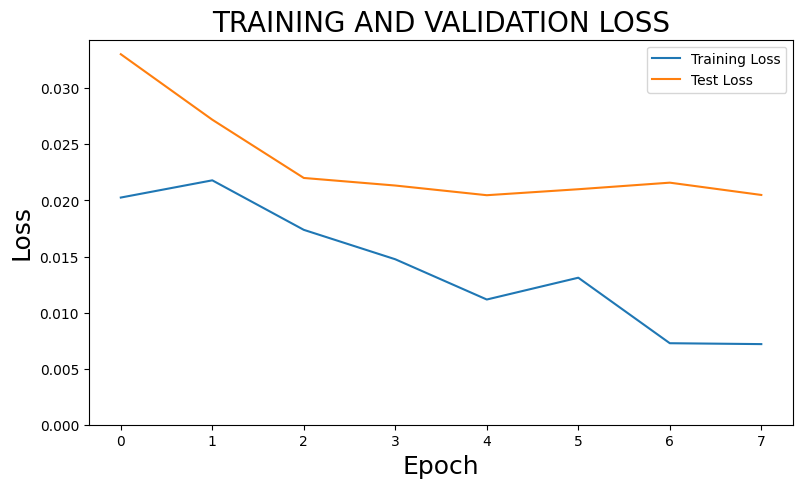

In [166]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.ylim([0,max(plt.ylim())])
plt.title('TRAINING AND VALIDATION LOSS', fontsize=20)
plt.show()

#Model Başarı Degerlendirme (Evaluation)

In [167]:
loss = model.evaluate(x_test,y_test, batch_size = 1)


47/47 [==============================] - 0s 3ms/step - loss: 0.0205


In [168]:
print("Test Loss:", loss*100.0)


Test Loss: 2.048925682902336


In [169]:
train_prediction_df = result_df[lookback:position]

In [170]:
train_prediction_df["Predicted"] = train_predict

In [171]:
train_prediction_df.head()

,Passangers,Predicted
Month,,
1949-02-01,118.0,135.248901
1949-03-01,132.0,138.382629
1949-04-01,129.0,147.812943
1949-05-01,121.0,145.792160
1949-06-01,135.0,140.403412


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Passangers'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['Predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['Passangers'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['Predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_4, *[[['Passangers', 'Predicted']]], **{})
chart

In [173]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()


,Passangers,Predicted
Month,,
1957-02-01,301.0,336.379547
1957-03-01,356.0,329.349609
1957-04-01,348.0,367.953278
1957-05-01,355.0,360.886200
1957-06-01,422.0,367.069885


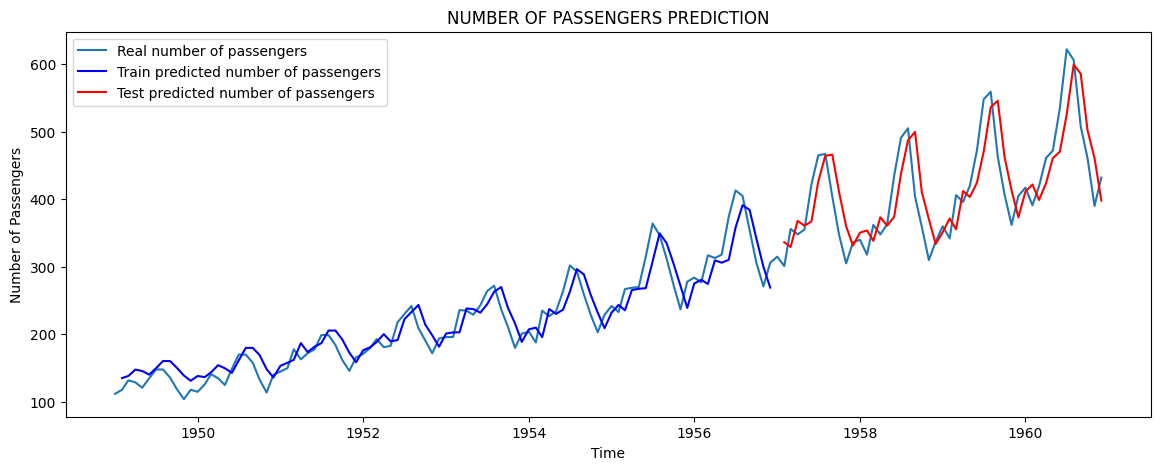

In [175]:
#Train ve Test Tahminleri ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real number of passengers')
plt.plot(train_prediction_df['Predicted'],color='blue',label='Train predicted number of passengers')
plt.plot(test_prediction_df['Predicted'],color='red',label='Test predicted number of passengers')
plt.title("NUMBER OF PASSENGERS PREDICTION")
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()